In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
    BaggingClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV
!pip install xgboost
!pip install shap

In [ ]:
# Loading the dataset
file_path = '/content/Turkana_LagsF (2).xlsx'
lags = pd.read_excel(file_path, sheet_name=None)

In [ ]:
#Looking at the data types
lags["L2"].dtypes

,0
villages,object
lat,float64
lon,float64
SUB_COUNTY,object
HOSPITAL,object
HOSPITAL_LAT,float64
HOSPITAL_LONG,float64
OUT_PATIENT,object
INDEX,int64
Village.ID,int64


In [ ]:
# Define hyperparameter grids
param_grids = {
    "Random Forest": {
        "n_estimators": [10, 20, 40, 80, 160, 320, 640],
        "max_depth": [None, 5, 10, 15, 20],
        "max_features": ["sqrt", "log2", None]
    },
    "Decision Tree": {
        "max_depth": [None, 5, 10, 15, 20],
        "max_features": ["sqrt", "log2", None]
    },
    "SVC": {
        "C": [0.5, 1, 1.5],
        "kernel": ["rbf", "sigmoid"]
    },
    "Naive Bayes": {},  # No hyperparameters for GaussianNB
    "AdaBoost": {
        "n_estimators": [10, 20, 40, 80, 160, 320, 640],
        "learning_rate": [0.1, 0.2, 0.3, 0.4, 0.5]
    },
    "Logistic Regression": {
        "C": [0.5, 1, 1.5]
    },
    "Extra Trees": {
        "n_estimators": [10, 20, 40, 80, 160, 320, 640],
        "max_depth": [None, 5, 10, 15, 20],
        "max_features": ["sqrt", "log2", None]
    },
    "Bagging": {
        "n_estimators": [10, 20, 40, 80, 160, 320, 640],
        "max_samples": [0.5, 0.75, 1.0]
    },
    "XGBoost": {
        "n_estimators": [10, 20, 40, 80, 160, 320, 640],
        "max_depth": [3, 6, 9, 12, 15],
        "learning_rate": [0.1, 0.2, 0.3, 0.4, 0.5],
        "subsample": [0.5, 0.75, 1.0]
    }
}


from xgboost import XGBClassifier

# Define models with default parameters
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVC": SVC(probability=True),
    "Naive Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(algorithm="SAMME"),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Extra Trees": ExtraTreesClassifier(),
    "Bagging": BaggingClassifier(DecisionTreeClassifier()),
    "XGBoost": XGBClassifier(objective="binary:logistic", eval_metric="logloss", random_state=42)
}

In [ ]:
# Function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for positive class

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    auc = roc_auc_score(y_test, y_prob)

    return accuracy, precision, recall, f1, auc

In [ ]:
# Feature selection
features = [
    "Sex",
    "Age",
    "Distance to Healthcare",
    "Population Density",
    "Distance to Water",
    "Elevation",
    "LULC",
    "Maximum Temperature",
    "Minimum Temperature",
    "Mean Temperature",
    "Mean Humidity",
    "Total Precipitation",
    "Forest Height",
    "Soil Type",
    "Greenness",
    "Brightness",
    "Wetness",
]

In [ ]:
# Looking at sheet names
print(lags.keys())
lag_data = lags['L1']
print(lag_data.columns)

dict_keys(['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8'])
Index(['villages', 'lat', 'lon', 'SUB_COUNTY', 'HOSPITAL', 'HOSPITAL_LAT',
       'HOSPITAL_LONG', 'OUT_PATIENT', 'INDEX', 'Village.ID',
       'VILLAGE.GEO.CORRDINATES.COUNTY.COUNTRY', 'SUB_COUNTY_OF_PATIENT',
       'Sex', 'Age', 'DATE_SEEN', 'RDT_rk39', 'Infections', 'date_lagged',
       'month', 'year', 'Distance to Healthcare', 'Population Density',
       'Distance to Water', 'Elevation', 'LULC', 'Maximum Temperature',
       'Minimum Temperature', 'Mean Temperature', 'Mean Humidity',
       'Total Precipitation', 'Forest Height', 'Soil Type', 'ET-Turkana-2016',
       'ET-Turkana-2017', 'ET-Turkana-2018', 'ET-Turkana-2019', 'Brightness',
       'Greenness', 'Wetness'],
      dtype='object')


In [ ]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

In [ ]:
available_columns = lag_data.columns
X = lag_data[[col for col in features if col in available_columns]]
print(X)
print(lags['L1'].columns.tolist())


         Sex   Age  Distance to Healthcare  Population Density  \
0     FEMALE  10.0               64.268103           219.44148   
1       MALE  10.0               64.268103           219.44148   
2       MALE  26.0               64.268103           219.44148   
3       MALE  15.0              164.523650            28.08550   
4       MALE   2.0              164.523650            28.08550   
...      ...   ...                     ...                 ...   
1297    MALE  13.0                1.162073           567.68340   
1298    MALE   3.0                1.162073           567.68340   
1299    MALE  10.0                1.162073           567.68340   
1300    MALE   5.0                1.162073           567.68340   
1301    MALE  15.0                1.162073           567.68340   

      Distance to Water  Elevation  LULC  Maximum Temperature  \
0              0.900000        383    10            35.530817   
1              0.900000        383    10            35.764856   
2           

In [ ]:
# Set global random seeds for reproducibility
np.random.seed(42)
random.seed(42)
os.environ["PYTHONHASHSEED"] = "42"

# Sort lags to ensure consistent processing order
sorted_lag_keys = sorted(lags.keys())

# Initialize scaler
scaler = StandardScaler()
metrics_data = []

# Loop through each lag in sorted order
for lag_name in sorted_lag_keys:
    lag_data = lags[lag_name]
    X = lag_data[features]
    y = lag_data["Infections"]

    # One-hot encode categorical variables
    X_encoded = pd.get_dummies(X, drop_first=True)

    # Split the data before scaling
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y, test_size=0.2, random_state=42  # Fixed random state
    )

    # Fit scaler on training data only
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train models with hyperparameter tuning
    for model_name, model in models.items():
        param_grid = param_grids.get(model_name, {})

        # Ensure models with randomness have fixed random_state
        if hasattr(model, "random_state"):
            model.set_params(random_state=42)

        if param_grid:  # Apply GridSearch if hyperparameters exist
            cv_strategy = KFold(n_splits=5, shuffle=False)
            grid_search = GridSearchCV(model, param_grid, cv=cv_strategy, scoring="roc_auc")
            grid_search.fit(X_train_scaled, y_train)
            best_model = grid_search.best_estimator_
        else:
            best_model = model.fit(X_train_scaled, y_train)

        # Re-ensure random state consistency
        if hasattr(best_model, "random_state"):
            best_model.set_params(random_state=42)

        # Evaluate model
        accuracy, precision, recall, f1, auc = evaluate_model(best_model, X_test_scaled, y_test)

        # Store results
        metrics_data.append(
            {
                "Lag": lag_name,
                "Model": model_name,
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1-Score": f1,
                "AUC": auc,
            }
        )

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

In [ ]:
# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_data)

In [ ]:
# Determine best model and lag per metric
best_results = {
    metric: {
        "Best Lag": metrics_df.loc[metrics_df[metric].idxmax()]["Lag"],
        "Best Model": metrics_df.loc[metrics_df[metric].idxmax()]["Model"],
    }
    for metric in ["Accuracy", "Precision", "Recall", "F1-Score", "AUC"]
}

# Display best results
print(pd.DataFrame(best_results))

               Accuracy    Precision       Recall     F1-Score       AUC
Best Lag             L4           L4           L4           L4        L3
Best Model  Extra Trees  Extra Trees  Extra Trees  Extra Trees  AdaBoost


In [ ]:
# Identify the seven best models based on AUC
best_models_df = metrics_df.nlargest(5, 'AUC')
print("Top 7 models based on AUC:\n", best_models_df[['Model', 'Lag', 'AUC']])

Top 7 models based on AUC:
             Model Lag       AUC
22       AdaBoost  L3  0.711746
65            SVC  L8  0.710777
31       AdaBoost  L4  0.706899
0   Random Forest  L1  0.705077
4        AdaBoost  L1  0.704813


In [ ]:
# Pivot the DataFrame to show performance metrics for each model across lags
performance_table = metrics_df.pivot_table(
    index=["Lag"],
    columns=["Model"],
    values=["Accuracy", "Precision", "Recall", "F1-Score", "AUC"]
)

# Display the table
print(performance_table)

            AUC                                                          \
Model  AdaBoost   Bagging Decision Tree Extra Trees Logistic Regression   
Lag                                                                       
L1     0.704813  0.666794      0.585057    0.621988            0.676343   
L2     0.666912  0.646022      0.565636    0.693677            0.663298   
L3     0.711746  0.654248      0.673199    0.701228            0.666295   
L4     0.706899  0.668939      0.615025    0.703843            0.656834   
L5     0.700552  0.682072      0.638207    0.661564            0.657363   
L6     0.676960  0.666676      0.627600    0.663121            0.657128   
L7     0.688212  0.685509      0.641350    0.672758            0.661946   
L8     0.681308  0.684217      0.656805    0.679692            0.664062   

                                                     Accuracy  ... Precision  \
Model Naive Bayes Random Forest       SVC   XGBoost  AdaBoost  ...   XGBoost   
Lag           

In [ ]:
performance_table.to_csv("model_performance_across_lags.csv")

In [ ]:
#Looking at AUC for Adaboost  L3
# Ensure reproducibility
np.random.seed(42)
random.seed(42)
os.environ["PYTHONHASHSEED"] = "42"

# Step 1: Prepare Data for Lag 3 (use the specific lag data)
best_lag_name = 'L3'  # Lag 3
lag_data = lags[best_lag_name]

# Define the features and target
X = lag_data[features]
y = lag_data["Infections"]

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Scaling the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Fit AdaBoost model with default parameters
adaboost_default = AdaBoostClassifier(random_state=42)
adaboost_default.fit(X_train_scaled, y_train)

# Step 3: Compute AUC for AdaBoost (default) on the test set
def compute_auc(model, X_test, y_test):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_pred_prob)

auc_default = compute_auc(adaboost_default, X_test_scaled, y_test)

# Output the AUC for AdaBoost Default on Lag 3
print(f"AdaBoost Default AUC (Lag 3): {auc_default:.4f}")


AdaBoost Default AUC (Lag 3): 0.7098


<ipython-input-27-13dc8d3b88cd>:49: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train, plot_type="bar")


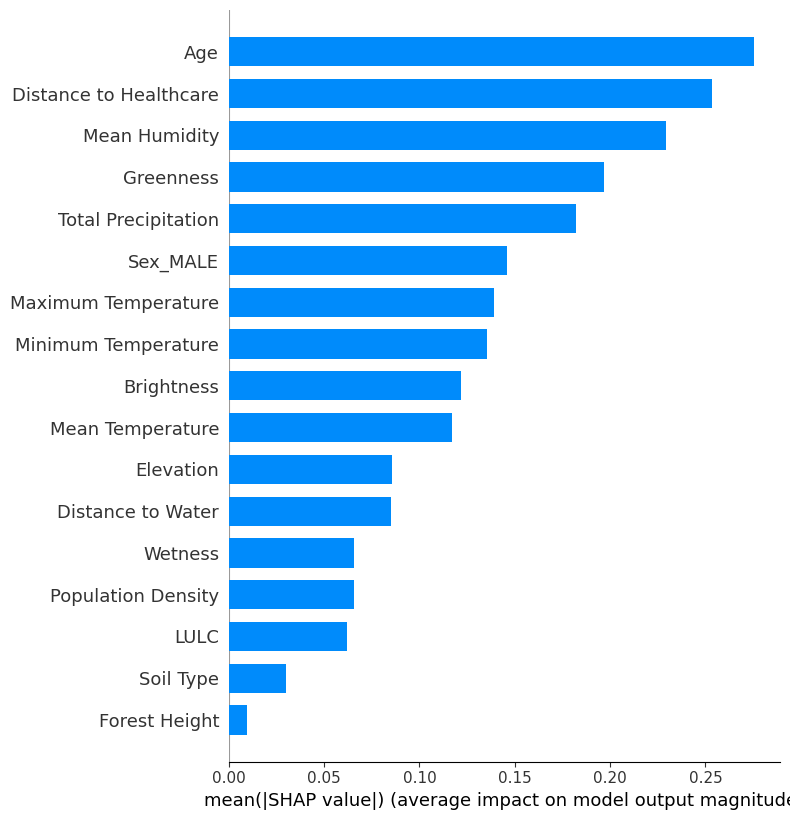

<ipython-input-27-13dc8d3b88cd>:52: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


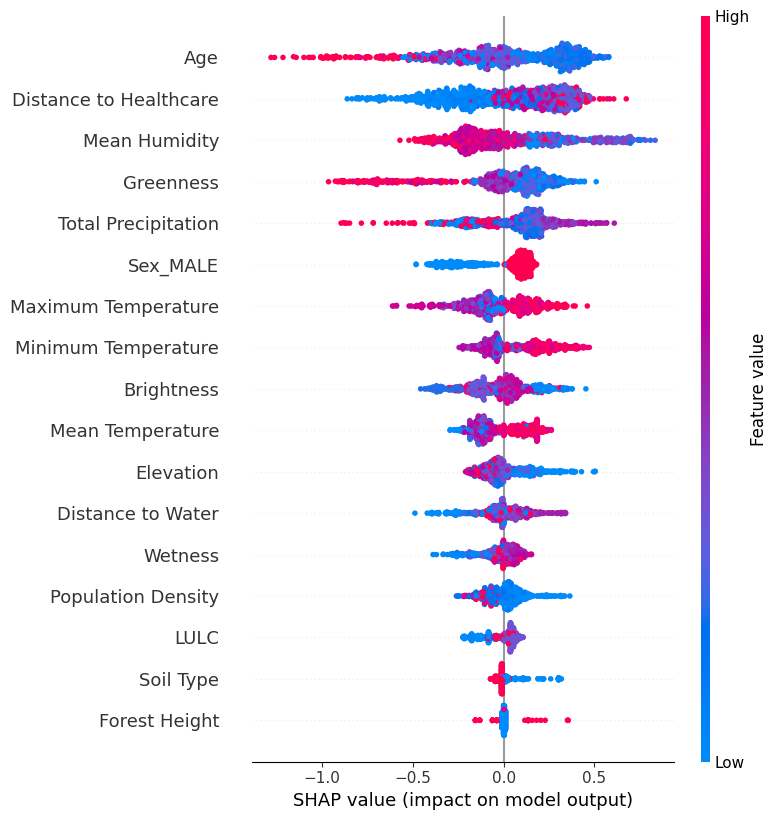

In [ ]:
# Shap for hypertunned model which has better AUC than the default one
# Ensure reproducibility
np.random.seed(42)
random.seed(42)
os.environ["PYTHONHASHSEED"] = "42"

# Step 1: Prepare Data for Lag 3
best_lag_name = 'L3'
lag_data = lags[best_lag_name]

# Define the features and target
X = lag_data[features]
y = lag_data["Infections"]

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Scaling the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Retrieve the hypertuned AdaBoost model from GridSearchCV

adaboost_hypertuned = grid_search.best_estimator_

# Step 3: SHAP Analysis on the hypertuned AdaBoost model

explainer = shap.Explainer(adaboost_hypertuned)
shap_values = explainer.shap_values(X_train_scaled)

# SHAP bar plot: Feature importance (global explanation)
shap.summary_plot(shap_values, X_train, plot_type="bar")

# SHAP beeswarm plot: Individual SHAP values (global explanation)
shap.summary_plot(shap_values, X_train)


In [ ]:
path="/content/Turkana_LagsF (2).csv"
df = pd.read_csv(path)
df.head(5)

,villages,lat,lon,SUB_COUNTY,HOSPITAL,HOSPITAL_LAT,HOSPITAL_LONG,OUT_PATIENT,INDEX,Village.ID,...,Mean Humidity,Total Precipitation,soil_type,ET-Turkana-2016,ET-Turkana-2017,ET-Turkana-2018,ET-Turkana-2019,Brightness,Wetness,Greenness
0,"AKATUMAN, KANGATOSA",3.50,36.04,TURKANA CENTRAL,COUNTY REFERRAL HOSPITAL,3.12,35.60,NO,5,1,...,63.13,0.000046,4,19.0,16.5,21.5,20.0,28243.46511,-2976.746173,-3329.769204
1,"AKATUMAN, KANGATOSA",3.50,36.04,TURKANA CENTRAL,COUNTY REFERRAL HOSPITAL,3.12,35.60,NO,6,1,...,64.73,0.000017,4,19.0,16.5,21.5,20.0,28243.46511,-2976.746173,-3329.769204
2,"AKATUMAN, KANGATOSA",3.50,36.04,TURKANA CENTRAL,COUNTY REFERRAL HOSPITAL,3.12,35.60,NO,7,1,...,64.73,0.000017,4,19.0,16.5,21.5,20.0,28243.46511,-2976.746173,-3329.769204
3,APOST,3.31,35.57,TURKANA WEST,LOPIDING,4.20,34.38,YES,14,2,...,57.78,0.000000,9,5.0,5.0,5.5,5.0,28243.46511,-2976.746173,-3329.769204
4,APOST,3.31,35.57,TURKANA WEST,LOPIDING,4.20,34.38,YES,15,2,...,57.45,0.000000,9,5.0,5.0,5.5,5.0,28043.95704,-2258.494747,-2745.092603


In [ ]:
future =pd.read_csv("/content/Turkana_Projection_Data_March2025.csv")
future.head()

,Longtitude,Latitude,ID,prec_oct_2,prec_nov_2,prec_dec_2,tmax_oct_2,tmax_nov_2,tmax_dec_2,tmin_oct_2,...,Elevation,soil_type,forest_height,LULC,tempmax,mean_temp,tempmin,Brightness,Greenness,Wetness
0,36.398365,0.944834,2,0.000016,0.000028,0.000014,29.886444,27.411285,27.757507,18.360657,...,1290,4.0,3,20,28.918862,23.012672,17.373205,0.294412,0.078242,0.020368
1,36.421321,0.951827,3,0.000016,0.000028,0.000014,29.886444,27.411285,27.757507,18.360657,...,1351,1.0,3,20,30.317640,24.303080,18.433425,0.287297,0.069669,0.007490
2,36.318389,1.001946,4,0.000017,0.000029,0.000014,31.636658,29.193268,29.566376,20.132263,...,1199,7.0,2,20,32.578083,26.141508,19.811066,0.343446,0.038169,-0.043483
3,36.354265,0.989159,5,0.000016,0.000027,0.000013,31.107452,28.624725,28.996094,19.593231,...,1059,4.0,8,20,30.317640,24.303080,18.433425,0.359598,0.069905,-0.036576
4,36.391877,0.984027,6,0.000016,0.000027,0.000013,31.107452,28.624725,28.996094,19.593231,...,1222,4.0,3,20,30.317640,24.303080,18.433425,0.321202,0.107953,0.002111


In [ ]:
# Add jitter to lat/lon (to avoid duplicate locations)
df['lat_jittered'] = df['lat'] + np.random.uniform(-1e-5, 1e-5, len(df))
df['lon_jittered'] = df['lon'] + np.random.uniform(-1e-5, 1e-5, len(df))

# Bind lat and lon into a single coordinate
df['coords'] = list(zip(df['lat_jittered'], df['lon_jittered']))

# Define predictor variables
predictors = [
    "tempmin", "Elevation", "Greenness", "Wetness", "Brightness", "soil_type",
    "mean_temp", "tempmax", "population_density", "LULC", "forest_height"
]

# Extract X and y
X = df[predictors]
y = df['Infections']

In [ ]:
# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Convert columns with potential commas to numeric
for col in X_train.select_dtypes(include=['object']).columns:
    X_train[col] = X_train[col].str.replace(',', '').astype(float)
    X_test[col] = X_test[col].str.replace(',', '').astype(float)

# Standardize the predictor variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train AdaBoost model
adaboost_model = AdaBoostClassifier(n_estimators=100, random_state=123)
adaboost_model.fit(X_train_scaled, y_train)

# Train Extra Trees model
extra_trees_model = ExtraTreesClassifier(n_estimators=100, random_state=123)
extra_trees_model.fit(X_train_scaled, y_train)

# Make predictions for the test set
adaboost_pred = adaboost_model.predict(X_test_scaled)
extra_trees_pred = extra_trees_model.predict(X_test_scaled)

# Evaluate models
adaboost_accuracy = accuracy_score(y_test, adaboost_pred)
extra_trees_accuracy = accuracy_score(y_test, extra_trees_pred)


In [ ]:
# Import the confusion_matrix function from sklearn.metrics
from sklearn.metrics import confusion_matrix

print("Extra Trees Confusion Matrix:")
print(confusion_matrix(y_test, extra_trees_pred))
print("AdaBoost Confusion Matrix:")
print(confusion_matrix(y_test, adaboost_pred))

Extra Trees Confusion Matrix:
[[95 39]
 [65 62]]
AdaBoost Confusion Matrix:
[[107  27]
 [ 77  50]]


In [ ]:
# Rename the latitude and longitude columns to 'lat' and 'lon'
future.rename(columns={'Latitude': 'lat', 'Longtitude': 'lon'}, inplace=True)

# --- Add jitter to future lat/lon
future['lat_jittered'] = future['lat'] + np.random.uniform(-1e-5, 1e-5, len(future))
future['lon_jittered'] = future['lon'] + np.random.uniform(-1e-5, 1e-5, len(future))

# --- Bind lat and lon into a single coordinate
future['coords'] = list(zip(future['lat_jittered'], future['lon_jittered']))

# Define the  predictor variables
predictors = [
    "tempmin", "Elevation", "Greenness", "Wetness", "Brightness", "soil_type",
    "mean_temp", "tempmax", "population_density", "LULC", "forest_height"
]

# Preprocess future data (similar to training data)
X_future = future[predictors]

# Handle non-numeric values
X_future = X_future.apply(pd.to_numeric, errors='coerce')

# Handle missing values
X_future.fillna(X_future.mean(), inplace=True)

# Standardize the future data using the same scaler fitted on the training data
X_future_scaled = scaler.transform(X_future)


#  Restore column names to scaled future data
X_future_scaled = pd.DataFrame(X_future_scaled, columns=X_future.columns)


# Get probability estimates for AdaBoost
adaboost_future_probs = adaboost_model.predict_proba(X_future_scaled)[:, 1]
# Get probability estimates for Extra Trees
extra_trees_future_probs = extra_trees_model.predict_proba(X_future_scaled)[:, 1]

#Add the probabilities to the future dataframe
future['AdaBoost Infection Probability'] = adaboost_future_probs
future['Extra Trees Infection Probability'] = extra_trees_future_probs

# --- Print predictions ---
print("Future Predictions (Infection Probabilities):")
print(future[['lat', 'lon', 'AdaBoost Infection Probability', 'Extra Trees Infection Probability']])

Future Predictions (Infection Probabilities):
           lat        lon  AdaBoost Infection Probability  \
0     0.944834  36.398365                        0.508360   
1     0.951827  36.421321                        0.508360   
2     1.001946  36.318389                        0.527123   
3     0.989159  36.354265                        0.466070   
4     0.984027  36.391877                        0.508360   
...        ...        ...                             ...   
2660  4.950112  35.530168                        0.547117   
2661  4.992416  35.331623                        0.633750   
2662  5.004559  35.370791                        0.667850   
2663  5.043992  35.414783                        0.667850   
2664  5.050104  35.437647                        0.667850   

      Extra Trees Infection Probability  
0                              0.608333  
1                              0.628333  
2                              0.566667  
3                              0.608333  
4          

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(


In [ ]:
# Save the future predictions to a CSV file
future.to_csv('future_infection_predictions.csv', index=False)

print("Predictions saved as 'future_infection_predictions.csv'")


Predictions saved as 'future_infection_predictions.csv'
